# ML Evaluation: GT mask vs Predicted mask

## 1. Objective

This notebook compares the machine learning classification performance for glioma grading (LGG vs HGG), by answering following questions:

1) GT-mask setting (upper bound):  
   If segmentation is perfect (ground-truth mask), how well can classical ML classify glioma grade (HGG vs LGG) from extracted features?

2) Pred-mask setting (real pipeline):
   If the DL model's predicted tumor mask will be used, how well can the same ML classifiers classify grade?

This notebook compares metrics, not feature columns, since GT-feature CSV and Pred-feature CSV can have different feature sets (each is evaluated on its own features).

The results are visualized, so comparison will be easier to see. 
For visualization two settings are used:
- bar plot of mean cross-validation metrics
- confusion matrices (per fold + mean)

The main goal is to identify how segmentation errors can affect the classification performance and to decide whether final end-to-end pipeline can be used in real world scenarios.


## 2. Environment setup and library imports

In this step, all required Python libraries are imported. These libraries required for data handling, numerical computation, visualization, and evaluation.

In [19]:
import os
from pathlib import Path

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.base import clone

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

# Make results reproducible
SEED = 42
np.random.seed(SEED)

## 3. Define configuration

In this step the paths to the dataset files and output folders are defined, using relative paths from the project root.
This avoids hardcoded `C:\Users\...` paths, so the notebook works on any machine as long as the project structure is the same.

In [20]:
# Project root = folder containing this notebook (works if notebook lives in notebooks/)
# If the notebook was moved elsewhere, adjust PROJECT_ROOT accordingly.
PROJECT_ROOT = Path.cwd()

# Common locations where notebooks usually is
if (PROJECT_ROOT / "outputs").exists() is False and (PROJECT_ROOT.parent / "outputs").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

print("PROJECT_ROOT:", PROJECT_ROOT)

FEATURES_GT_CSV = PROJECT_ROOT / "outputs" / "ml_features" / "features_from_gtmask.csv"
FEATURES_PRED_CSV = PROJECT_ROOT / "outputs" / "ml_predmask_features" / "features_from_predmask.csv"

print("GT features CSV:", FEATURES_GT_CSV)
print("Pred features CSV:", FEATURES_PRED_CSV)

assert FEATURES_GT_CSV.exists(), f"Missing: {FEATURES_GT_CSV}"
assert FEATURES_PRED_CSV.exists(), f"Missing: {FEATURES_PRED_CSV}"

PROJECT_ROOT: c:\Users\Nurma\Desktop\thesis
GT features CSV: c:\Users\Nurma\Desktop\thesis\outputs\ml_features\features_from_gtmask.csv
Pred features CSV: c:\Users\Nurma\Desktop\thesis\outputs\ml_predmask_features\features_from_predmask.csv


## 4. Load feature tables (GT and Pred)

Both CSVs must contain:
- `patient_id`
- `label_hgg` (target: 1 = HGG, 0 = LGG)
- many feature columns

GT and Pred tables have different numbers of features.

In [21]:
def load_features_table(csv_path: Path) -> pd.DataFrame:
    #Load a feature CSV into a pandas DataFrame
    df = pd.read_csv(csv_path)
    return df

df_gt = load_features_table(FEATURES_GT_CSV)
df_pred = load_features_table(FEATURES_PRED_CSV)

print("GT shape:", df_gt.shape)
print("Pred shape:", df_pred.shape)

print("\nGT columns (first 10):", list(df_gt.columns)[:10])
print("Pred columns (first 10):", list(df_pred.columns)[:10])

GT shape: (321, 106)
Pred shape: (321, 48)

GT columns (first 10): ['bbox_dx', 'bbox_dy', 'bbox_dz', 'bbox_volume_vox', 'contrast_flair_mean_minus_ring', 'contrast_t1_mean_minus_ring', 'contrast_t1c_mean_minus_ring', 'contrast_t2_mean_minus_ring', 'label_hgg', 'patient_id']
Pred columns (first 10): ['patient_id', 'fold', 'label_hgg', 'tumor_voxels', 'tumor_voxel_fraction', 'bbox_h', 'bbox_w', 'bbox_z', 'tumor_slices', 'tumor_centroid_h']


## 5. Dataset overview 

The "UCSF-PDGM" dataset includes 321 patients with available MRI scans and clinical labels. The dataset has a strong class imbalance, (more HGG than LGG). The class counts for transparency are counted, this helps interpret confusion matrices and metrics.

In [22]:
def summarize_labels(df: pd.DataFrame, name: str):
    y = df["label_hgg"].astype(int)
    counts = y.value_counts().sort_index()  # 0=LGG, 1=HGG
    lgg = int(counts.get(0, 0))
    hgg = int(counts.get(1, 0))
    n = int(len(y))
    print(f"--- {name} ---")
    print(f"Total: {n}")
    print(f"LGG (0): {lgg}")
    print(f"HGG (1): {hgg}")
    print(f"LGG %: {100*lgg/n:.1f}% | HGG %: {100*hgg/n:.1f}%")
    print()

summarize_labels(df_gt, "GT-mask features")
summarize_labels(df_pred, "Pred-mask features")

--- GT-mask features ---
Total: 321
LGG (0): 33
HGG (1): 288
LGG %: 10.3% | HGG %: 89.7%

--- Pred-mask features ---
Total: 321
LGG (0): 33
HGG (1): 288
LGG %: 10.3% | HGG %: 89.7%



# 6. Build (X, y) separately for GT and Pred

This section does not intersect feature columns since the main goal is to evaluate:
- GT features (ML performance upper bound)
- Pred features (end-to-end performance)

Additionally, specific columns that do not contain usable features (IDs and text columns) are removed.

In [23]:
TARGET_COL = "label_hgg"

# Columns that explicitly are excluded from features
NON_FEATURE_COLS = {
    "patient_id",
    "label_hgg",
    "who_cns_grade",
    "ucsf_id_used_for_label",
    "diagnosis_text",
    "fold",  # if present
}

def to_xy(df: pd.DataFrame):
    """Convert a features DataFrame into (X, y, feature_names)."""
    if TARGET_COL not in df.columns:
        raise ValueError(f"Missing target column '{TARGET_COL}'")

    # Target vector (HGG=1, LGG=0)
    y = df[TARGET_COL].astype(int).values

    # Drop known non-feature columns
    feat_df = df.drop(columns=[c for c in NON_FEATURE_COLS if c in df.columns], errors="ignore")

    # Keep numeric columns only
    feat_df = feat_df.select_dtypes(include=[np.number])

    if feat_df.shape[1] == 0:
        raise ValueError("No numeric feature columns found after filtering NON_FEATURE_COLS.")

    X = feat_df.values.astype(np.float32)
    feature_names = list(feat_df.columns)
    return X, y, feature_names

X_gt, y_gt, feat_gt = to_xy(df_gt)
X_pred, y_pred, feat_pred = to_xy(df_pred)

print("GT: X shape =", X_gt.shape, "| numeric features =", len(feat_gt))
print("Pred: X shape =", X_pred.shape, "| numeric features =", len(feat_pred))

GT: X shape = (321, 104) | numeric features = 104
Pred: X shape = (321, 45) | numeric features = 45


## 7. Define ML Models (Logistic Regression and Random Forest)

This section compares two ML models:

#### Logistic Regression (LogReg)
- linear classifier
- benefits from feature scaling
- robust / interpretable

#### Random Forest (RF)
- non-linear ensemble of decision trees
- handles complex feature interactions
- less sensitive to scaling

In [24]:
def make_models(seed: int = 42):
    # Return a dict of sklearn models/pipelines to evaluate

    # Logistic Regression pipeline:
    # - StandardScaler makes each feature have mean=0, std=1 (important for LogReg)
    # - class_weight='balanced' helps when HGG/LGG is imbalanced
    logreg = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            random_state=seed,
        )),
    ])

    # Random Forest:
    # - class_weight='balanced' also helps imbalance
    rf = RandomForestClassifier(
        n_estimators=400,
        random_state=seed,
        class_weight="balanced",
        n_jobs=-1,
    )

    return {"LogReg": logreg, "RF": rf}

MODELS = make_models(SEED)
list(MODELS.keys())

['LogReg', 'RF']

## 8. 5-fold cross-validation evaluation

The 5-fold cross-validation is used, since it gives a more reliable estimate of model performance than a single train/test split, especially for limited medical datasets. In each fold, approximately 64 patients (≈ 20%) are used for validation. Each patient appears in the validation set exactly once across the 5 folds.

This fucntion evaluates each model with StratifiedKFold so each fold has a similar HGG/LGG ratio.

Metrics computed per fold:
- ROC-AUC
- Accuracy
- F1
- Precision
- Recall (Sensitivity)
- Specificity (computed from confusion matrix)

Then the result is reported as mean ± std across all folds.

In [25]:
def specificity_from_cm(cm: np.ndarray) -> float:
    #Specificity = TN / (TN + FP) for binary confusion matrix
    tn, fp, fn, tp = cm.ravel()
    denom = (tn + fp)
    return float(tn / denom) if denom > 0 else np.nan

def eval_model_cv(X: np.ndarray, y: np.ndarray, model, k: int = 5, seed: int = 42):
    #Run k-fold CV and return per-fold metrics + aggregated summary
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    fold_rows = []
    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y)):
        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        # Fit
        model.fit(X_tr, y_tr)

        # Predict probabilities if available (needed for AUC)
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_te)[:, 1]
        else:
            # fallback (rare for our chosen models)
            proba = model.decision_function(X_te)

        pred = (proba >= 0.5).astype(int)

        auc = roc_auc_score(y_te, proba)
        acc = accuracy_score(y_te, pred)
        f1 = f1_score(y_te, pred, zero_division=0)
        prec = precision_score(y_te, pred, zero_division=0)
        rec = recall_score(y_te, pred, zero_division=0)

        cm = confusion_matrix(y_te, pred, labels=[0, 1])
        spec = specificity_from_cm(cm)

        fold_rows.append({
            "fold": fold,
            "n_test": int(len(te_idx)),
            "auc": float(auc),
            "accuracy": float(acc),
            "f1": float(f1),
            "precision": float(prec),
            "recall_sensitivity": float(rec),
            "specificity": float(spec),
        })

    fold_df = pd.DataFrame(fold_rows)

    summary = {
        "mean_auc": float(fold_df["auc"].mean()),
        "std_auc": float(fold_df["auc"].std(ddof=0)),
        "mean_accuracy": float(fold_df["accuracy"].mean()),
        "std_accuracy": float(fold_df["accuracy"].std(ddof=0)),
        "mean_f1": float(fold_df["f1"].mean()),
        "std_f1": float(fold_df["f1"].std(ddof=0)),
        "mean_precision": float(fold_df["precision"].mean()),
        "mean_recall_sensitivity": float(fold_df["recall_sensitivity"].mean()),
        "mean_specificity": float(fold_df["specificity"].mean()),
    }

    return fold_df, summary

## 9. Run evaluation: GT-mask setting (upper bound)

Here the ML models are evaluated using GT_mask derived features.

In [26]:
gt_results = []

for model_name, model in MODELS.items():
    fold_df, summary = eval_model_cv(X_gt, y_gt, model, k=5, seed=SEED)
    gt_results.append({
        "setting": "GT mask (perfect segmentation)",
        "model": model_name,
        **summary
    })

gt_results_df = pd.DataFrame(gt_results).sort_values("mean_auc", ascending=False)
gt_results_df

,setting,model,mean_auc,std_auc,mean_accuracy,std_accuracy,mean_f1,std_f1,mean_precision,mean_recall_sensitivity,mean_specificity
1,GT mask (perfect segmentation),RF,0.959316,0.028439,0.918894,0.027068,0.955838,0.014939,0.933990,0.979250,0.395238
0,GT mask (perfect segmentation),LogReg,0.956309,0.018582,0.918846,0.032020,0.953746,0.018635,0.971769,0.937568,0.766667


## 10. Run evaluation: Pred-mask setting (end-to-end pipeline)

Here the ML models are evaluated using features from DL-predicted masks.

In [27]:
pred_results = []

for model_name, model in MODELS.items():
    fold_df, summary = eval_model_cv(X_pred, y_pred, model, k=5, seed=SEED)
    pred_results.append({
        "setting": "Pred mask (end-to-end)",
        "model": model_name,
        **summary
    })

pred_results_df = pd.DataFrame(pred_results).sort_values("mean_auc", ascending=False)
pred_results_df

,setting,model,mean_auc,std_auc,mean_accuracy,std_accuracy,mean_f1,std_f1,mean_precision,mean_recall_sensitivity,mean_specificity
0,Pred mask (end-to-end),LogReg,0.962963,0.018217,0.909712,0.022698,0.947762,0.013777,0.981924,0.916697,0.852381
1,Pred mask (end-to-end),RF,0.955734,0.018984,0.909663,0.011630,0.951227,0.006581,0.921927,0.982638,0.276190


## 11. Combined comparsion table (GT vs Pred)

This table is the final result for the ML part:
- which model works best in the ideal setting (GT mask)
- which model works best in the real end-to-end setting (Pred mask)
- how much performance drops when using predicted masks

In [28]:
comparison_df = pd.concat([gt_results_df, pred_results_df], axis=0, ignore_index=True)

# Show a clean subset of columns first
cols_show = [
    "setting", "model",
    "mean_auc", "std_auc",
    "mean_accuracy", "std_accuracy",
    "mean_f1", "std_f1",
    "mean_precision", "mean_recall_sensitivity", "mean_specificity"
]

comparison_df[cols_show]

,setting,model,mean_auc,std_auc,mean_accuracy,std_accuracy,mean_f1,std_f1,mean_precision,mean_recall_sensitivity,mean_specificity
0,GT mask (perfect segmentation),RF,0.959316,0.028439,0.918894,0.027068,0.955838,0.014939,0.933990,0.979250,0.395238
1,GT mask (perfect segmentation),LogReg,0.956309,0.018582,0.918846,0.032020,0.953746,0.018635,0.971769,0.937568,0.766667
2,Pred mask (end-to-end),LogReg,0.962963,0.018217,0.909712,0.022698,0.947762,0.013777,0.981924,0.916697,0.852381
3,Pred mask (end-to-end),RF,0.955734,0.018984,0.909663,0.011630,0.951227,0.006581,0.921927,0.982638,0.276190


## 12. Best model per setting 

This section selects the best model by "mean AUC" (same meaning as mean ROC-AUC).

In [29]:
def best_model_row(df: pd.DataFrame) -> pd.Series:
    return df.sort_values("mean_auc", ascending=False).iloc[0]

best_gt = best_model_row(gt_results_df)
best_pred = best_model_row(pred_results_df)

print("Best model (GT-mask setting):")
print(best_gt[["model", "mean_auc", "mean_accuracy", "mean_f1"]].to_string())
print()

print("Best model (Pred-mask setting):")
print(best_pred[["model", "mean_auc", "mean_accuracy", "mean_f1"]].to_string())

Best model (GT-mask setting):
model                  RF
mean_auc         0.959316
mean_accuracy    0.918894
mean_f1          0.955838

Best model (Pred-mask setting):
model              LogReg
mean_auc         0.962963
mean_accuracy    0.909712
mean_f1          0.947762


## 13. Bar plot visualization: best model perfomance (GT-mask vs Pred-mask)

This section creates bar plots of the best models in each settings since bar plots give an immediate visual comparsion between GT-mask and Pred-mask settings. Each best model is selected based on its mean_auc, then plotted key metrics side-by-side.

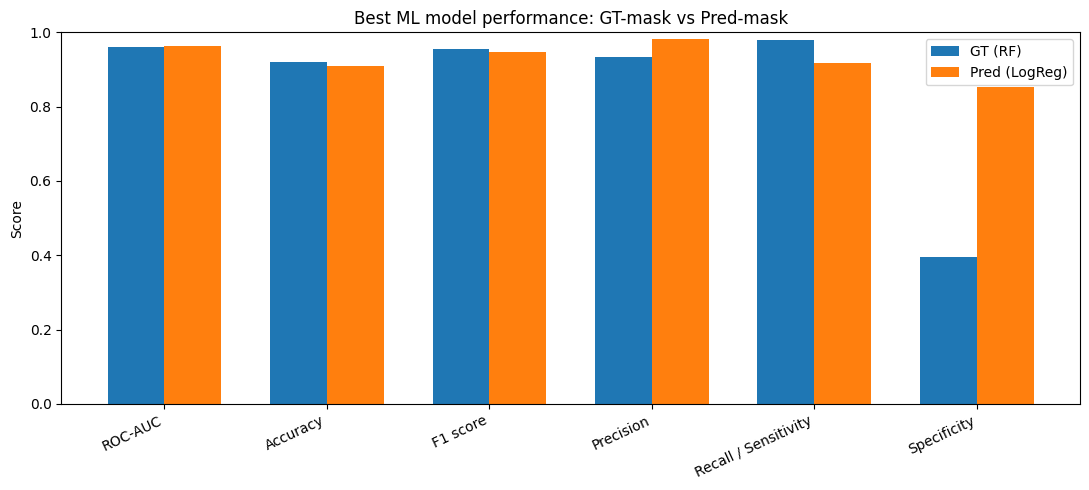

In [31]:
# Make the setting names robust 
# Sometimes the 'setting' values can be 'GT-mask', 'GT mask', 'Pred-mask', etc.
# To avoid errors, a cleaned version is created 
comparison_df = comparison_df.copy()  # avoid modifying earlier objects in-place
comparison_df["setting_clean"] = (
    comparison_df["setting"].astype(str).str.strip().str.lower()
)

# Select rows belonging to GT-like and Pred-like settings
gt_rows = comparison_df[comparison_df["setting_clean"].str.contains("gt")]
pred_rows = comparison_df[comparison_df["setting_clean"].str.contains("pred")]

# Safety check: fail early with a helpful message if filtering did not work.
if len(gt_rows) == 0 or len(pred_rows) == 0:
    raise ValueError(
        "Could not split comparison_df into GT and Pred settings.\n"
        f"Unique settings found: {comparison_df['setting'].unique()}"
    )

# Pick the best model within each setting using mean_auc
best_gt = gt_rows.sort_values("mean_auc", ascending=False).iloc[0]
best_pred = pred_rows.sort_values("mean_auc", ascending=False).iloc[0]

# Choose which metrics to visualize
metrics_to_plot = [
    ("mean_auc", "ROC-AUC"),
    ("mean_accuracy", "Accuracy"),
    ("mean_f1", "F1 score"),
    ("mean_precision", "Precision"),
    ("mean_recall_sensitivity", "Recall / Sensitivity"),
    ("mean_specificity", "Specificity"),
]

labels = [label for _, label in metrics_to_plot]
gt_values = [float(best_gt[m]) for m, _ in metrics_to_plot]
pred_values = [float(best_pred[m]) for m, _ in metrics_to_plot]

# Plot
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(11, 5))
plt.bar(x - width/2, gt_values, width, label=f"GT ({best_gt['model']})")
plt.bar(x + width/2, pred_values, width, label=f"Pred ({best_pred['model']})")

plt.xticks(x, labels, rotation=25, ha="right")
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Best ML model performance: GT-mask vs Pred-mask")
plt.legend()
plt.tight_layout()
plt.show()


Based on the bar plot, both settings achieve high ROC-AUC, accuracy, and F1-score, which indicates strong ability for glioma grade classification in both cases.

Interestingly, the Pred-mask model achieves higher specificity compared to the GT-mask model. Specificity measures how well the model correctly identifies LGG cases (true negatives). This suggests that the Pred-mask-based classifier is less likely to incorrectly label LGG tumors as HGG.

In contrast, the GT-mask model achieves higher recall/sensitivity, which means it is more
aggressive in detecting HGG cases, at the cost of a higher false-positive rate for LGG. This behavior is expected since the more detailed features were extracted from ground-truth segmentations.

Overall, the GT-mask model prioritizes detecting all HGG cases, while the Pred-mask model better preserves specificity for LGG. Importantly, the Pred-mask results demonstrate that the end-to-end pipeline remains highly effective despite using automatically generated segmentations.


## 14. Confusion matrices (GT-mask vs Pred-mask)

This step visualizes how the best-performing ML models classify patients into LGG and HGG classes. The confusion matrices are displayed as percentage-based, since it makes the comparison between GT-mask and Pred-mask settings clearer and easier to interpret.


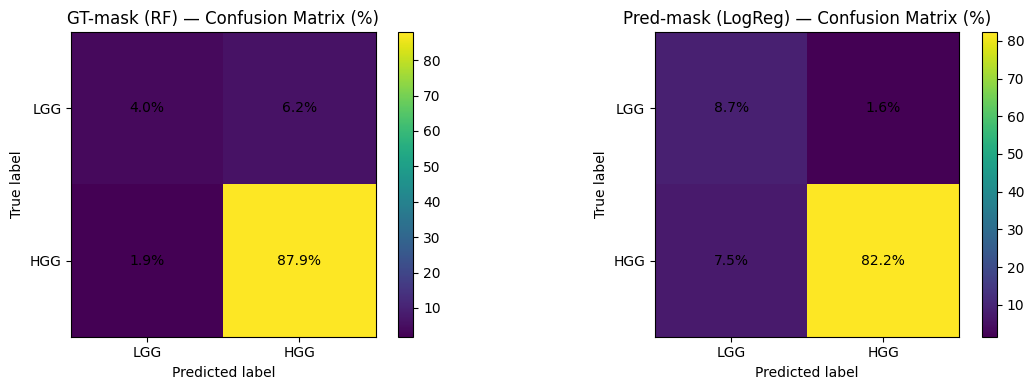

In [32]:
K_FOLDS = int(globals().get("K_FOLDS", 5))
SEED = int(globals().get("SEED", 42))

best_gt_model = MODELS[best_gt["model"]]
best_pred_model = MODELS[best_pred["model"]]

# Get global CV predictions (each patient once)
def cv_predictions_global(X, y, model, n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    y_true_all, y_pred_all = [], []

    for train_idx, test_idx in skf.split(X, y):
        m = clone(model)
        m.fit(X[train_idx], y[train_idx])

        if hasattr(m, "predict_proba"):
            probs = m.predict_proba(X[test_idx])[:, 1]
            preds = (probs >= 0.5).astype(int)
        else:
            preds = m.predict(X[test_idx]).astype(int)

        y_true_all.append(y[test_idx])
        y_pred_all.append(preds)

    return np.concatenate(y_true_all), np.concatenate(y_pred_all)

# Compute predictions
y_true_gt, y_pred_gt = cv_predictions_global(
    X_gt, y_gt, best_gt_model, n_splits=K_FOLDS, seed=SEED
)

y_true_pred, y_pred_pred = cv_predictions_global(
    X_pred, y_pred, best_pred_model, n_splits=K_FOLDS, seed=SEED
)

# Confusion matrices (0 = LGG, 1 = HGG)
cm_gt = confusion_matrix(y_true_gt, y_pred_gt, labels=[0, 1]).astype(float)
cm_pred = confusion_matrix(y_true_pred, y_pred_pred, labels=[0, 1]).astype(float)

# Convert to percentages
cm_gt_pct = 100 * cm_gt / cm_gt.sum()
cm_pred_pct = 100 * cm_pred / cm_pred.sum()

# Plotting function
def plot_cm_percent(ax, cm_pct, title, class_names=("LGG", "HGG")):
    im = ax.imshow(cm_pct, interpolation="nearest")
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm_pct[i, j]:.1f}%", ha="center", va="center")

    return im

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# GT confusion matrix 
im1 = plot_cm_percent(
    axes[0],
    cm_gt_pct,
    title=f"GT-mask ({best_gt['model']}) — Confusion Matrix (%)",
)
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Pred confusion matrix 
im2 = plot_cm_percent(
    axes[1],
    cm_pred_pct,
    title=f"Pred-mask ({best_pred['model']}) — Confusion Matrix (%)",
)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

#### GT-mask (Random Forest)

The Random Forest classifier achieves a very high correct classification rate for HGG cases (87.9%). Only 1.9% of HGG cases are misclassified as LGG, indicating strong sensitivity for high-grade gliomas.

For LGG cases, the correct classification rate is lower (4.0%), while 6.2% of LGG cases are incorrectly predicted as HGG. This behavior is expected due to the strong imbalance in the dataset, where the number of LGG patients is smaller than the number of HGG patients.

Overall, the GT-mask confusion matrix reflects an upper-bound scenario, where perfect tumor segmentation allows the classifier to rely on accurate features.

#### Pred-mask (Logistic Regression)

In the end-to-end pipeline using predicted segmentation masks, the Logistic Regression classifier correctly identifies 82.2% of HGG cases. Although slightly lower than in the GT-mask setting, this result demonstrates that the pipeline remains highly effective.

The LGG classification performance shows 8.7% correct predictions, while 1.6% of LGG cases are misclassified as HGG. Compared to the GT-mask setting, the Pred-mask model exhibits higher LGG specificity, but at the cost of slightly reduced HGG recall.



## 15. Summary

#### GT-mask setting (upper bound)

Using ground-truth tumor masks, the ML classifier achieves very strong performance, with high ROC-AUC, accuracy, and F1-score. The Random Forest classifier performs best in this scenario, indicating that non-linear decision boundaries are well suited for rich, high-quality radiomic-style features. This setting represents an idealized upper bound, as the extracted features are derived from perfectly segmented tumors.

#### Pred-mask setting (real pipeline)

Logistic Regression performs best in this setting, suggesting that the linear model is more suitable for imperfect segmentation. When using predicted tumor masks from the deep learning segmentation model, classification performance decreases slightly but remains consistently high. The drop in performance is expected and reflects realistic deployment conditions, not a failure of the pipeline.


#### Overall conclusion

The GT-mask setting confirms that tumor-derived features contain strong predictive signals for glioma grading. While the Pred-mask setting demonstrates that the proposed end-to-end pipeline remains effective without requiring manual annotations. The observed performance gap between GT-mask and Pred-mask settings is the cost of imperfect segmentation, which is acceptable for the fully automated workflow. This work demonstrate that the end-to-end pipeline can preform automated glioms segmentation and grading.


#### Future Improvements
Potential improvement includes to train the ML models on larger and more balanced datasets to improve LGG detection.

